In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from experiment import LightningVAE
from metrics.mcc import mcc


In [50]:
def draw_res(recons, input, latents, **kwargs):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].imshow(input.squeeze().detach().cpu().permute(1,2,0).numpy())
    axs[0].set_title("Input")
    axs[1].imshow(recons.squeeze().detach().cpu().permute(1,2,0).numpy())
    axs[1].set_title("Reconstruction")
    print(latents)
    plt.show()

In [62]:
model = LightningVAE.load_from_checkpoint("/cs/labs/yweiss/adirt/lab_project/vae-lab-project/lightning_logs/h2sycu3v/checkpoints/epoch=99-step=12500.ckpt")
model.eval()


Hidden dims:  [8, 16, 32, 64]


LightningVAE(
  (model): VanillaVAE(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [63]:
shapes = np.load("data/shapes_32x32_10000.npy")
sources = np.load("data/sources_10000_d=2.npy")

[0.2160397  0.11619051]


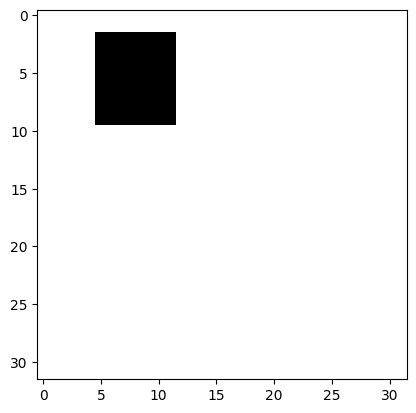

In [27]:
i = 9
plt.imshow(shapes[i])
print(sources[i])

In [64]:
shapes[:64]
im = torch.tensor(shapes[:64]).permute(0, 3, 1, 2).float() / 255.0
res = model.model(im.to(model.device))
# draw_res(**res)

In [83]:
latents = res["latents"].permute(1, 0).detach().cpu().numpy()
sources = sources[:64].T
print(latents.shape)
print(sources.shape)

(2, 64)
(2, 64)


In [84]:
curr_mcc, corr_sort, sort_idx, latents = mcc(latents, sources)
# plt.scatter(latents[:, 1], sources[:, 0])

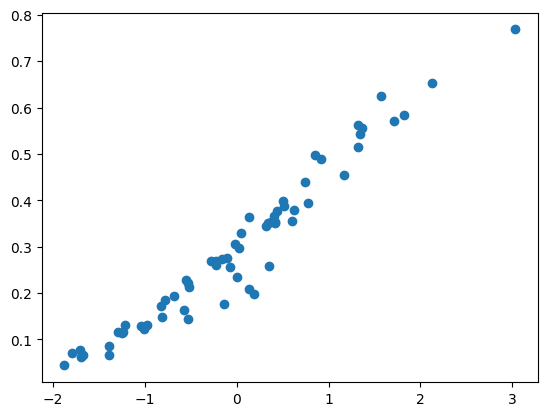

In [90]:
plt.scatter(latents[1, :], sources[1, :])

In [119]:
t = np.random.randn(2, 2)
a = np.random.randn(2, 3)

# Stack them together
b = np.hstack((t, a))
b.shape

(2, 5)

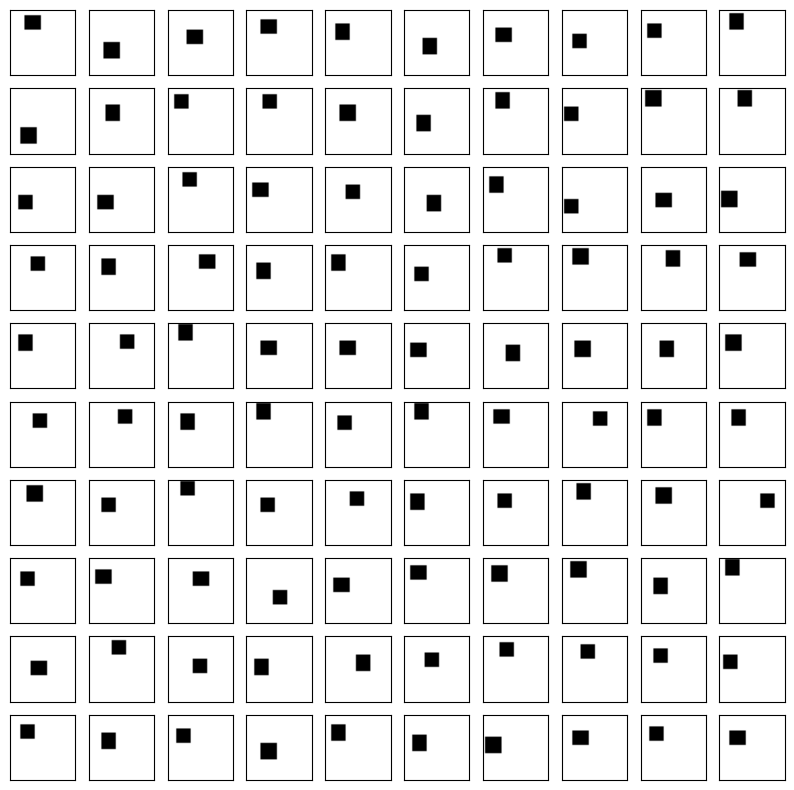

In [11]:
# Define the grid size
grid_size = 10

# Create a figure and axis
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

# Iterate through the images and plot them
for i, ax in enumerate(axes.flat):
    # If there are fewer images than grid cells, hide the remaining empty plots
    if i < m.shape[0]:
        ax.imshow(m[i])
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.axis('off')
        ax.set_visible(False)

plt.show()

In [3]:
npx = np.random.rand(2, 3, 32, 32).astype(np.float32)
x = torch.Tensor(npx)
j = model(x)


In [15]:
# j[0][0].detach().numpy().transpose(1, 2, 0)
plt.imshow(j[0][0].detach().numpy().transpose(1, 2, 0))

array([[[-0.21055928,  0.04126837,  0.13222559],
        [-0.24939789, -0.14848007, -0.10389824],
        [-0.46378392, -0.2724796 ,  0.28930557],
        ...,
        [ 0.01129521, -0.06534824, -0.0836994 ],
        [ 0.10690145, -0.12390669,  0.23714538],
        [ 0.08895503, -0.0445008 , -0.0525538 ]],

       [[-0.22361828,  0.23042154,  0.13246098],
        [-0.2759644 ,  0.3332795 , -0.06351516],
        [-0.45264253,  0.74151886, -0.36202615],
        ...,
        [-0.05208807,  0.14300722, -0.23552863],
        [-0.10298625,  0.09435927, -0.14895596],
        [-0.05585251, -0.11756548, -0.11724118]],

       [[-0.34662598,  0.06921551, -0.00556397],
        [ 0.1007173 ,  0.05595879,  0.38143772],
        [ 0.11756782,  0.8814636 , -0.17857897],
        ...,
        [-0.02090594, -0.08075953,  0.18209253],
        [-0.22592387,  0.1109147 ,  0.29263172],
        [-0.12955087,  0.10874332, -0.06551334]],

       ...,

       [[-0.22262889,  0.08635124,  0.07197537],
        [-0